In [1]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.82GB/s]


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.4 MB/s eta 0:00:00


In [4]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torch import nn
import random
import imghdr
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
from PIL import Image
import seaborn as sns
import math
import optuna

/tmp/ipython-input-2107703102.py:9: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
dirs = ['fear', 'disgust', 'angry', 'happy', 'surprise', 'sad', 'neutral']
valid_files = ['jpg', 'jpeg', 'bmp', 'gif', 'png']

for dir in dirs:
  abs_path = os.path.join('train', dir)

  for img_path in os.listdir(abs_path):

    img_path = os.path.join(abs_path, img_path)
    try:

      file_type = imghdr.what(img_path)
      if file_type not in valid_files:
        os.remove(img_path)

    except Exception as e:
      print(f'Issue with file {img_path}. Error: {e}')
      os.remove(img_path)


for dir in dirs:
  abs_path = os.path.join('test', dir)

  for img_path in os.listdir(abs_path):

    img_path = os.path.join(abs_path, img_path)
    try:

      file_type = imghdr.what(img_path)
      if file_type not in valid_files:
        os.remove(img_path)

    except Exception as e:
      print(f'Issue with file {img_path}. Error: {e}')
      os.remove(img_path)

In [8]:
# combining the img list with abs path
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

dirs = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

train_img_path = []
train_img_label = []

label_id = 0

for dir in dirs:
  abs_path = os.path.join('train', dir)
  imgs = [os.path.join(abs_path,img) for img in os.listdir(abs_path)]
  train_img_path.extend(imgs)
  label = [float(label_id)]*len(imgs)
  train_img_label.extend(label)
  label_id += 1

In [9]:
# for test data too

dirs = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

test_img_path = []
test_img_label = []

label_id = 0

for dir in dirs:
  abs_path = os.path.join('test', dir)
  imgs = [os.path.join(abs_path,img) for img in os.listdir(abs_path)]
  test_img_path.extend(imgs)
  label = [float(label_id)]*len(imgs)
  test_img_label.extend(label)
  label_id += 1

In [10]:
from collections import Counter

Counter(test_img_label), Counter(train_img_label)

(Counter({0.0: 958,
          1.0: 111,
          2.0: 1024,
          3.0: 1774,
          4.0: 1247,
          5.0: 831,
          6.0: 1233}),
 Counter({0.0: 3995,
          1.0: 436,
          2.0: 4097,
          3.0: 7215,
          4.0: 4830,
          5.0: 3171,
          6.0: 4965}))

In [11]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=45)
    ]
)

In [12]:
class CustomDataset(Dataset):

  def __init__(self, img_path_list, img_label_list, transform=None):
    self.img_path_list = img_path_list
    self.img_label_list = img_label_list
    self.transform = transform

  def __len__(self):
    return len(self.img_path_list)

  def __getitem__(self, idx):
    img, label = self.img_path_list[idx], self.img_label_list[idx]
    img = Image.open(img)

    if self.transform:
      img = self.transform(img)

    return img, label

In [13]:
traindataset = CustomDataset(train_img_path, train_img_label, transform=transform)
testdataset = CustomDataset(test_img_path, test_img_label, transform=transform)

In [14]:
traindataloader = DataLoader(traindataset, batch_size=100, shuffle=True, num_workers=2, pin_memory=True)
testdataloader = DataLoader(testdataset, batch_size=100, shuffle=True, num_workers=2, pin_memory=True)

In [15]:
class Model_with_Optuna(nn.Module):
  def __init__(self, activation_function, conv_kernal, conv_dropout, conv_channels, neurons, dense_dropout):
    super().__init__()
    feature_layers = []

    activation = getattr(nn, activation_function)

    in_channel = 1
    for channel, kernal, dropout in zip(conv_channels, conv_kernal, conv_dropout):
      feature_layers.append(nn.Conv2d(in_channels=in_channel, out_channels=channel, kernel_size=kernal, padding='same'))
      feature_layers.append(nn.BatchNorm2d(channel))
      feature_layers.append(activation())
      feature_layers.append(nn.Dropout2d(dropout))
      feature_layers.append(nn.MaxPool2d(2,2))
      in_channel = channel

    self.features = nn.Sequential(*feature_layers)

    with torch.no_grad():
      dummy = torch.zeros(1,1,48,48)
      out = self.features(dummy)
      inputs = out.flatten().shape[0]

    classification_layers = [nn.Flatten(), ]

    for neuron, dropout in zip(neurons, dense_dropout):
      classification_layers.append(nn.Linear(inputs, out_features=neuron))
      classification_layers.append(nn.BatchNorm1d(neuron))
      classification_layers.append(activation())
      classification_layers.append(nn.Dropout(p=dropout))
      inputs = neuron

    self.classifier = nn.Sequential(*classification_layers)

  def forward(self, img_path):
    output = self.features(img_path)
    output = self.classifier(output)
    return output

In [27]:
def objective(trial):

  learning_rate = trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001])
  epochs = trial.suggest_int('epochs', 10, 20)
  optimizer = trial.suggest_categorical('optimizer', ['RMSprop', 'Adam'])
  feature_layers = trial.suggest_categorical('num_feature_layers', [2,3,4,5])
  classification_layers = trial.suggest_categorical('num_categorical_layers', [2,3,4])
  activation_function = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh'])

  conv_channels = []
  conv_kernal = []
  conv_dropout = []
  for i in range(feature_layers):
    conv_kernal.append(trial.suggest_categorical(f'conv_kernal_size_in_layer_{i}', [2,3,4,5]))
    conv_dropout.append(trial.suggest_categorical(f'conv_drop_out_in_layer_{i}', [0.2,0.3,0.4]))
    conv_channels.append(trial.suggest_categorical(f'conv_channels_in_layer_{i}', [64, 128, 256, 32]))

  neurons = []
  dense_dropout = []

  for i in range(classification_layers):
    neurons.append(trial.suggest_categorical(f'num_of_neurons_in_layer_{i}', [32, 64, 128, 256]))
    dense_dropout.append(trial.suggest_categorical(f'dropout_in_layer_{i}', [0.1,0.2, 0.3, 0.4]))


  model = Model_with_Optuna(activation_function, conv_kernal, conv_dropout, conv_channels, neurons, dense_dropout)
  model = model.to(device)

  loss_function = nn.CrossEntropyLoss()

  optimizer_class = getattr(torch.optim, optimizer)

  optimizer = optimizer_class(model.parameters(), lr=learning_rate)

  for epoch in range(epochs):

    model.train()

    for imgs, labels in traindataloader:
      imgs, labels = imgs.to(device), labels.to(device)
      pred = model(imgs)

      loss = loss_function(pred, labels.long())

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    model.eval()

    with torch.no_grad():
      recall = []
      for imgs, labels in testdataloader:
        imgs = imgs.to(device)
        pred = model(imgs)
        pred = pred.argmax(dim=1)
        recall.append(recall_score(labels.cpu(), pred.cpu(), average='macro'))

    return np.mean(recall)

In [28]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=25)

[I 2026-01-07 11:33:29,823] A new study created in memory with name: no-name-9c8a274e-a6dc-4be2-a6ba-1d9c6d7c8424
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [29]:
study.best_params

{'learning_rate': 0.01,
 'epochs': 12,
 'optimizer': 'Adam',
 'num_feature_layers': 2,
 'num_categorical_layers': 3,
 'activation': 'Tanh',
 'conv_kernal_size_in_layer_0': 5,
 'conv_drop_out_in_layer_0': 0.3,
 'conv_channels_in_layer_0': 64,
 'conv_kernal_size_in_layer_1': 5,
 'conv_drop_out_in_layer_1': 0.4,
 'conv_channels_in_layer_1': 64,
 'num_of_neurons_in_layer_0': 128,
 'dropout_in_layer_0': 0.4,
 'num_of_neurons_in_layer_1': 128,
 'dropout_in_layer_1': 0.3,
 'num_of_neurons_in_layer_2': 128,
 'dropout_in_layer_2': 0.1}

In [30]:
study.best_value

0.22481034921654133

In [32]:
model = Model_with_Optuna(activation_function='Tanh', conv_kernal=[5,5], conv_dropout=[0.3, 0.4], conv_channels=[64, 64], neurons=[128, 128, 128], dense_dropout=[0.4, 0.3, 0.1])

In [34]:
model = model.to(device)

In [35]:
loss_function = nn.CrossEntropyLoss() # Changed to CrossEntropyLoss

learning_rate = 0.01
epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epochs):
  epoch_train_loss = []
  epoch_test_loss = []

  model.train()

  for imgs, labels in traindataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    pred = model(imgs) # pred are now logits

    loss = loss_function(pred, labels.long()) # Labels converted to long

    with torch.no_grad():
      epoch_train_loss.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  model.eval()

  with torch.no_grad():
    for imgs, labels in testdataloader:
      imgs, labels = imgs.to(device), labels.to(device)
      pred = model(imgs)
      loss = loss_function(pred, labels.long())
      epoch_test_loss.append(loss.item())


  current_train_loss = np.mean(np.array(epoch_train_loss))
  train_loss_per_epoch.append(current_train_loss)

  current_test_loss = np.mean(np.array(epoch_test_loss))
  test_loss_per_epoch.append(current_test_loss)
  print(f'at epoch {epoch} \n train loss is {current_train_loss} \n test loss is {current_test_loss}')

at epoch 0 
 train loss is 3.754681092997392 
 test loss is 3.2390162779225244
at epoch 1 
 train loss is 3.3922876475585833 
 test loss is 3.176157706313663
at epoch 2 
 train loss is 3.373432961603006 
 test loss is 3.159346987803777
at epoch 3 
 train loss is 3.361549866696199 
 test loss is 3.1513910392920175
at epoch 4 
 train loss is 3.361530713737011 
 test loss is 3.1473708980613284
at epoch 5 
 train loss is 3.360514144102732 
 test loss is 3.14513251847691
at epoch 6 
 train loss is 3.3584651996692023 
 test loss is 3.1433631115489535
at epoch 7 
 train loss is 3.3535971318682036 
 test loss is 3.141879290342331
at epoch 8 
 train loss is 3.3659321955508656 
 test loss is 3.1417236593034534
at epoch 9 
 train loss is 3.3521766107943325 
 test loss is 3.140760842296812
at epoch 10 
 train loss is 3.3531782370474605 
 test loss is 3.1403801672988467
at epoch 11 
 train loss is 3.35507350994481 
 test loss is 3.1410665214061737
at epoch 12 
 train loss is 3.3544240453177028 
 te

In [58]:
# # even after training for 50 epochs the loss is not reducing much

model.eval()

all_predictions = []
all_labels = []
with torch.no_grad():
  for imgs, labels in testdataloader:
    imgs = imgs.to(device)
    output = model(imgs)
    output = output.argmax(dim=1)
    all_predictions.extend(output.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

In [63]:
print('accuracy score : ', accuracy_score(all_labels, all_predictions))

accuracy score :  0.2641404290888827


In [64]:
print('recall score :', recall_score(all_labels, all_predictions, average='macro'))

recall score : 0.20667371102914503


In [65]:
mtx = confusion_matrix(all_labels, all_predictions)

<Axes: >

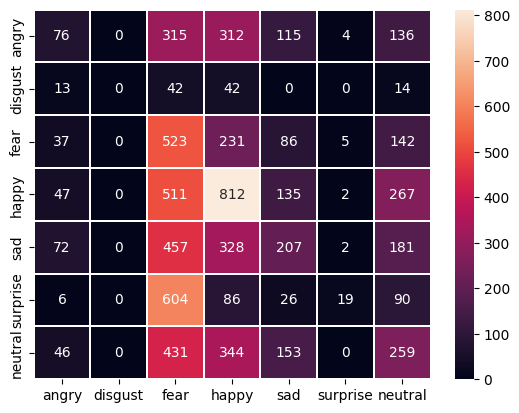

In [71]:
# not at all performing good

sns.heatmap(mtx, xticklabels=dirs, yticklabels=dirs, annot=True, fmt='d', linewidths=0.1)